In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 1.Выберите любой понравившийся вам набор данных

In [2]:
ratings = pd.read_csv(".\data\Magazine_Subscriptions.csv", header=None)
ratings.columns = ["userId", "itemId", "rating", "timestamp"]
ratings.head()

,userId,itemId,rating,timestamp
0,B00005N7P0,AH2IFH762VY5U,5.0,1005177600
1,B00005N7P0,AOSFI0JEYU4XM,5.0,1004486400
2,B00005N7OJ,A3JPFWKS83R49V,3.0,1174694400
3,B00005N7OJ,A19FKU6JZQ2ECJ,5.0,1163116800
4,B00005N7P0,A25MDGOMZ2GALN,5.0,1405296000


In [3]:
ratings.shape[0]

89689

### 2.Проведите базовый EDA - распределения рейтингов, количество уникальных товаров и т.д.

In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89689 entries, 0 to 89688
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     89689 non-null  object 
 1   itemId     89689 non-null  object 
 2   rating     89689 non-null  float64
 3   timestamp  89689 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 2.7+ MB


In [6]:
# распределение оценок
ratings.rating.value_counts()

5.0    53790
4.0    12676
1.0    11029
3.0     6971
2.0     5223
Name: rating, dtype: int64

<AxesSubplot: >

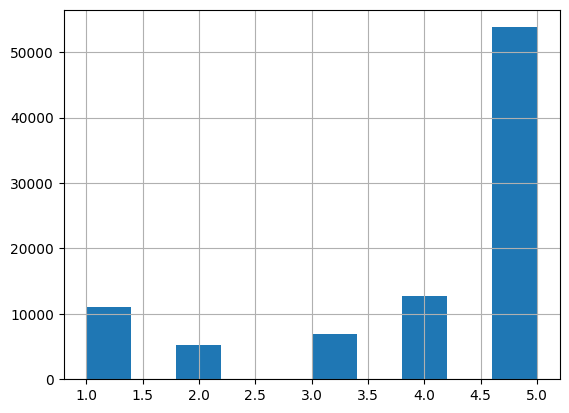

In [7]:
ratings.rating.hist()

In [8]:
# количество товаров
ratings.itemId.value_counts()

A3JPFWKS83R49V    55
A2OTUWUSH49XIN    26
AEMZRE6QYVQBS     25
A3GA09FYFKL4EY    24
A30H2335OM7RD6    22
                  ..
A1GOGNVAM9CWRK     1
A5RXVI67FLKMD      1
AGXYE9WZZ4DUG      1
ATYDFYTB5URNC      1
A1N6M7HRWMDE3D     1
Name: itemId, Length: 72098, dtype: int64

In [9]:
# количество пользователей
ratings.userId.value_counts()

B00005NIOH    1718
B00005N7Q1    1537
B00005N7SC    1480
B00007B10Y    1409
B001LF4EVO    1339
              ... 
B00VXCWV10       1
B0015RA2NC       1
B00BLB7P2I       1
B00VVGRBL8       1
B000063XJY       1
Name: userId, Length: 2428, dtype: int64

### 3.Отложите часть данных для тестирования.

In [10]:
def train_test_split_special(
    X,
    ratio=0.2,
    user_col="userId",
    item_col="itemId",
    rating_col="rating",
    time_col="timestamp",
):
    # сортируем оценки по времени
    X.sort_values(by=[time_col], inplace=True)
    # список всех юзеров
    userIds = X[user_col].unique()
    X_train_data = []
    X_test_data = []
    y_train = []
    y_test = []
    for userId in tqdm_notebook(userIds):
        curUser = X[X[user_col] == userId]
        # определяем позицию, по которой делим выборку и размещаем данные по массивам
        idx = int(curUser.shape[0] * (1 - ratio))
        X_train_data.append(curUser[[user_col, item_col]].iloc[:idx, :].values)
        X_test_data.append(curUser[[user_col, item_col]].iloc[idx:, :].values)
        y_train.append(curUser[rating_col].values[:idx])
        y_test.append(curUser[rating_col].values[idx:])
    # cтекуем данные по каждому пользователю в общие массивы
    X_train = pd.DataFrame(np.vstack(X_train_data), columns=[user_col, item_col])
    X_test = pd.DataFrame(np.vstack(X_test_data), columns=[user_col, item_col])
    y_train = np.hstack(y_train)
    y_test = np.hstack(y_test)
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = train_test_split_special(ratings)

  0%|          | 0/2428 [00:00<?, ?it/s]

In [12]:
X_train.shape, len(y_train), X_test.shape, len(y_test)

((70604, 2), 70604, (19085, 2), 19085)

In [13]:
X_train.userId.value_counts()

B00005NIOH    1374
B00005N7Q1    1229
B00005N7SC    1184
B00007B10Y    1127
B001LF4EVO    1071
              ... 
B00KAJOCVO       1
B01705ZPXY       1
B00006KMQ8       1
B000067FOL       1
B00R1Y13MC       1
Name: userId, Length: 2015, dtype: int64

In [14]:
X_train.itemId.value_counts()

A3JPFWKS83R49V    54
AEMZRE6QYVQBS     25
A1RPTVW5VEOSI     21
AKMEY1BSHSDG7     21
A30H2335OM7RD6    20
                  ..
A22U9WQAJKTR6X     1
A32GRPMAZJ74EZ     1
A2Y3WTME3GN12O     1
A1EYJ7WJMPH1Y8     1
A2W7LPBCJO1L7      1
Name: itemId, Length: 57554, dtype: int64

### 4.На основании вашего датасета постройте рекомендательную систему

# User-based model

**User-based model** является моделью коллабораивной фильтрации, основная идея которой **похожим пользователям обычно нравятся похожие объекты**

Идею алгоритма можно сформулировать следующим образом:

    1) Найти, насколько другие пользователи в базе данных похожи на данного пользователя.
    2) По оценкам других пользователей предсказать, какую оценку даст данный пользователь данному продукту, учитывая с большим весом тех пользователей, которые больше похожи на данный.


Определять схожесть $2$ пользователей будем с помощью корреляции Пирсона между векторами уже поставленными оценками. Отметим, что для двух различных пользователей оценка может иметь различный вес, так для одного средний фильм имеет рейтинг $2$, а для другого $4$. Такие пользователи похожи, но корреляция скажет, что они различны. Чтобы устранить это, давайте из всех оценок пользователя вычтем его среднюю оценку.

Таким образом итоговая формула схожести двух пользователей вычисляется по формуле:
$$
    \textit{sim(u, v)} = \frac
    {\sum_i{\big((r_{ui} - \overline{r_u}) \times (r_{vi} - \overline{r_v})\big)}}
    {\sqrt{\sum_i{(r_{ui} - \overline{r_u})^2}} \times \sqrt{\sum_i{(r_{vi} - \overline{r_v})^2}}}
$$

Интуитивно понятно, что предпологаемый рейтинг для пользователя можно оценить как средний рейтинг между схожими пользователями, но, благодаря введению понятия схожести, можно улучшить эту оценку, введя взвешенные веса и учитывая всех пользователей, которые посмотрели этот фильм.

Итак, приближаем новый рейтинг как средний рейтинг данного пользователя плюс отклонения от среднего рейтингов других пользователей, взвешенных весам (т. е. похожестью):
$$
    r_{ui} = \overline{r_u} + \frac
    {\sum_{v \in User_i}\big(\textit{sim(u, v)} \times (r_{vi} - \overline{r_v})\big)}
    {\sum_{v \in User_i}\textit{sim(u, v)}}
$$



In [15]:
class UserBased(BaseEstimator):
    def fit(self, X, y, user_col="userId", item_col="itemId"):
        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()

        X["y"] = y

        # рассчитаем среднее значение рейтинга для пользователя
        self.mean_y_user = X.groupby(user_col)["y"].mean()

        # вычитаем среднюю оценку пользователя
        X["y"] -= X[user_col].apply(lambda x: self.mean_y_user[x])

        # создаём векторы для каждого пользователя из предметов
        # для неизвестных объектов ставим среднюю оценку
        self.user_ratings = pd.pivot_table(
            X,
            values="y",
            index=user_col,
            columns=item_col,
            fill_value=mean(self.mean_y_user),
        )  #

        # считаем попарную схожесть между юзерами
        self.user_sim = cosine_similarity(self.user_ratings)

        # также сделаем словарь - {значение user_col: index в user_ratings}
        self.user_pos = dict()
        for user in self.users:
            self.user_pos[user] = np.argwhere(self.user_ratings.index.values == user)[
                0
            ][0]
        return self

    def predict_rating(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём среднее
        if not pr_item in self.items or not pr_user in self.users:
            return mean(self.mean_y_user)

        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.user_sim[self.user_pos[pr_user]].dot(
            self.user_ratings.loc[:, pr_item]
        )

        # вычитаем 1, так как схожесть пользователя с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = self.user_sim[self.user_pos[pr_user]].sum() - 1

        return self.mean_y_user[pr_user] + numerator / denominator

    def predict(self, X, user_col="userId", item_col="itemId"):
        y = X[[user_col, item_col]].apply(
            lambda row: self.predict_rating(row[0], row[1]), axis=1
        )
        return y

# Item-based model
Ищем похожие товары:


    1) Найти, насколько другие продукты в базе данных похожи на данный продукт.
    
    2) По оценкам других продуктов предсказать, какую оценку даст данный пользователь данному продукту, учитывая с большим весом те продукты, которые больше похожи на данный.


При вычислении $r_{ui}$ мы посмотрим на все фильмы пользователя $u$, оценим их схожесть с фильмом $i$ и посчитаем взвешенную сумму:
$$
    r_{ui} = \overline{r_i} + \frac
    {\sum_{j \in Item_u}\big(\textit{sim(i, j)} \times (r_{uj} - \overline{r_j})\big)}
    {\sum_{j \in Item_u}\textit{|sim(i, j)|}}
$$

Оценивать же схожесть двух фильмов будем с помощью корреляции Пирсона:
$$
    \textit{sim(i, j)} = \frac
    {\sum_u{\big((r_{ui} - \overline{r_i}) \times (r_{uj} - \overline{r_j})\big)}}
    {\sqrt{\sum_u{(r_{ui} - \overline{r_i})^2}} \times \sqrt{\sum_u{(r_{uj} - \overline{r_j})^2}}}
$$

In [16]:
class ItemBased(BaseEstimator):
    def fit(self, X, y, user_col="userId", item_col="itemId"):
        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()

        X["y"] = y
        # рассчитаем среднее значение рейтинга для предмета
        self.mean_y_item = X.groupby(item_col)["y"].mean()

        # вычитаем среднюю оценку предмета
        X["y"] -= X[item_col].apply(lambda x: self.mean_y_item[x])

        # создаём векторы для каждого фильма с оценками пользователя
        # если пользователь не поставил оценку, то ставим среднюю оценку
        self.item_ratings = pd.pivot_table(
            X,
            values="y",
            index=item_col,
            columns=user_col,
            fill_value=mean(self.mean_y_item),
        )

        # считаем попарную схожесть между фильмами
        self.item_sim = cosine_similarity(self.item_ratings)

        # также сделаем словарь {значение item_col: index в item_ratings}
        self.item_pos = dict()
        for item in self.items:
            self.item_pos[item] = np.argwhere(self.item_ratings.index.values == item)[
                0
            ][0]
        return self

    def predict_rating(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём среднее
        if not pr_item in self.items or not pr_user in self.users:
            return mean(self.mean_y_item)

        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.item_sim[self.item_pos[pr_item]].dot(
            self.item_ratings.loc[:, pr_user]
        )
        # вычитаем 1, так как схожесть предмета с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = self.item_sim[self.item_pos[pr_item]].sum() - 1

        return self.mean_y_item[pr_item] + numerator / denominator

    def predict(self, X, user_col="userId", item_col="itemId"):
        y = X[[user_col, item_col]].apply(
            lambda row: self.predict_rating(row[0], row[1]), axis=1
        )
        return y

### 5.Оцените качество полученных рекомендаций, при помощи подходящих метрик

In [17]:
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

### UserBased

In [18]:
ub = UserBased().fit(X_train, y_train)
y_predicted = ub.predict(X_test)

In [19]:
y_predicted[y_predicted < 1] = 1
y_predicted[y_predicted > 5] = 5

In [20]:
print("rmse = {}".format(rmse(y_test, y_predicted)))

rmse = 1.5238321486900877


### ItemBased

In [21]:
ib = ItemBased().fit(X_train, y_train)
y_predicted1 = ib.predict(X_test)

In [ ]:
y_predicted1[y_predicted1 < 1] = 1
y_predicted1[y_predicted1 > 5] = 5

In [ ]:
print("rmse = {}".format(rmse(y_test, y_predicted1)))

rmse = 1.5172675001156442


### Всем пятерки

In [ ]:
y_predicted2 = np.zeros(len(y_predicted1)) + 5

In [ ]:
rmse(y_test, y_predicted2)

1.8046602264357756